In [1]:
import pandas as pd
import numpy as np
import plotly.express as px

import plotly.graph_objects as go

In [2]:
# df do indice
df = pd.read_csv('dados/retorno_portfolio.csv', parse_dates=['Date'])
df.fillna(0, inplace=True)

df_gsrai = pd.read_csv('dados/GSRAII.csv', parse_dates=['Date']).sort_values('Date')

df = df.merge(df_gsrai, on='Date')

# Colocar variação percentual pct_change()
df['retorno'] = df['ACWI'] #ACWI


df['retorno acumulado'] = df['retorno'] + 1
df['retorno acumulado'] = df['retorno acumulado'].cumprod()

df.drop(columns=['ACWI', 'BCOM Index', 'JPEGCOMP Index', 'SP500BDT Index', 'DGS10', 'retorno'], inplace=True)

df.sort_values('Date', inplace=True)
df['year_week'] = df['Date'].dt.strftime('%Y-%U')

In [3]:
#%% Semanal
df_gp = df.groupby('year_week').agg('last')

In [4]:
# df_gp['pct'] = df_gp['retorno acumulado'].pct_change() *100
# for pct in range(1,6):
#     df_gp[f'pct_{pct}_sem'] = (df_gp['retorno acumulado']/df_gp['retorno acumulado'].shift(pct).values
#                               -1) * 100
    
    
for pct in range(1,6):
    df_gp[f'pct_{pct}_sem'] = (df_gp['retorno acumulado'].shift(pct*-1).values/
                               df_gp['retorno acumulado'] -1) * 100

In [5]:
df_gp['mean'] = df_gp['GSRAII Index'].rolling(3).mean()

up_down = df_gp['mean']

limit =  df_gp['GSRAII Index'].mean() #-.0  #0.9   # media -0.08605222734255 
df_gp['gsrai_gt_up'] = np.where((df_gp['GSRAII Index'] > up_down) & (df_gp['GSRAII Index'] >= limit), 1, 0)
df_gp['gsrai_gt_down'] = np.where((df_gp['GSRAII Index'] < up_down) & (df_gp['GSRAII Index'] >= limit), 1, 0)
df_gp['gsrai_lt_up'] = np.where((df_gp['GSRAII Index'] > up_down) & (df_gp['GSRAII Index'] < limit), 1, 0)
df_gp['gsrai_lt_down'] = np.where((df_gp['GSRAII Index'] < up_down) & (df_gp['GSRAII Index'] < limit), 1, 0)

In [7]:
lista = []
regras = ['gsrai_gt_up', 'gsrai_gt_down', 'gsrai_lt_up', 'gsrai_lt_down']
pct =  'pct_1_sem'
for col in regras:
    desc = df_gp[df_gp[col]==1][[pct]].describe().rename(columns={pct: col})
    lista.append(desc)
pd.concat(lista, axis=1)

,gsrai_gt_up,gsrai_gt_down,gsrai_lt_up,gsrai_lt_down
count,406.000000,288.000000,281.000000,316.000000
mean,0.031383,0.167278,0.124969,0.015174
std,0.998323,1.183258,1.483199,1.908497
min,-3.207523,-5.086255,-5.458140,-12.463035
25%,-0.615800,-0.388021,-0.666702,-0.709173
50%,0.098664,0.218621,0.302990,0.098210
75%,0.629824,0.867373,1.045256,0.963819
max,4.007751,4.497400,6.200290,7.311105


In [8]:
lista=[]
for col in regras:
    df_desc = df_gp[df_gp[col]==1][[pct]]#.describe().rename(columns={pct: col})
    m_lower, m_upper = df_desc.std()*-2+df_desc.mean(), df_desc.std()*2+df_desc.mean()
    df_desc = df_desc[(df_desc>m_lower)&(df_desc<m_upper)].dropna()
    df_desc.rename(columns={pct: col}, inplace=True)
    desc = df_desc.describe()
    lista.append(desc)
pd.concat(lista, axis=1)

,gsrai_gt_up,gsrai_gt_down,gsrai_lt_up,gsrai_lt_down
count,387.000000,272.000000,267.000000,300.000000
mean,0.031191,0.240149,0.214401,0.053582
std,0.853886,0.914796,1.203402,1.280640
min,-1.951268,-2.146853,-2.808120,-3.731906
25%,-0.547566,-0.290609,-0.508341,-0.674230
50%,0.100395,0.231290,0.360410,0.098210
75%,0.613443,0.827952,1.044456,0.931244
max,2.006440,2.481622,2.982455,3.069377


<AxesSubplot:>

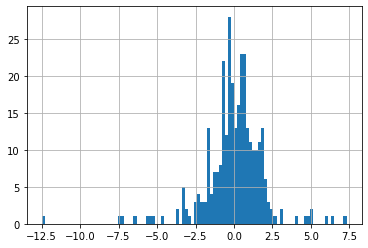

In [9]:
df_gp[df_gp[regras[3]]==1][pct].hist(bins=100)

In [12]:
np.quantile(df_gp[pct].dropna(),0.05, axis=0)

-2.107949631176398

In [ ]:
pct =  'pct_2sem'
cut = df_gp[pct].quantile(0.95)
df_gp[(df_gp[pct]>=cut)].sum()

In [ ]:
df_gp[(df_gp['pct_ret']>cut) & (df_gp['gsrai_lt_down']==1)]['pct_ret'].describe()

In [ ]:
df_gp['2020-01':'2020-18']

In [11]:
df_gp[(df_gp['pct_ret']>0) & (df_gp['gsrai_lt_down']==1)].index

KeyError: 'pct_ret'

In [ ]:
df_gp['2019-35':'2019-45']

In [ ]:
df_gp[(df_gp['pct_ret']<0) & (df_gp['gsrai_lt_down']==1)]['pct_ret'].describe()

In [ ]:
df_gp[(df_gp['gsrai_lt_down']==1)]['pct_ret'].describe()

In [ ]:
df_gp[(df_gp['gsrai_lt_down']==1)]['pct_ret_shift'].describe()

In [ ]:
#%%


df_corr= df_gp[df_gp['category']==1].corr()

df_all = df_gp.merge(df, right_on='year_week', left_on='year_week' , how='outer')
[['category','year_week', 'Date_y', 'GSRAII Index_y', 'retorno_y']]
df_all = df_all[df_all['category']==0]

df_all_gp = df_all.groupby('year_week').agg(['std', 'sum', 'min', 'max'])


df_filtrado = df_all[(df_all['year_week']=='2020-12') | (df_all['year_week']=='2020-11')]





#%% Grafico

fig = px.line(df, x="Date", y=['GSRAII Index', 'retorno acumulado'])

# fig = px.line(df_gp, x="Date", y=['GSRAII Index', 'pct_ret'])

fig.add_trace(go.Scatter(
    x=df_gp[df_gp['category']==1]['Date'],
    y=df_gp[df_gp['category']==1]['pct_ret'],
    marker_size=10, mode='markers', name='Queda',
    ))

fig.show()